In [1]:
import os
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing as skpreprocessing
from sklearn.model_selection import train_test_split, ParameterGrid, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, HuberRegressor, ElasticNet, LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
np.set_printoptions(precision=3, suppress=True)
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from pylab import rcParams

In [2]:
cwd = os.getcwd()
output_dir = os.path.join(cwd, "../../data")
df = pd.read_csv(os.path.join(output_dir, "combined_nodeinfo.csv"))
df_test = pd.read_csv(os.path.join(output_dir, "combined_nodeinfotest.csv"))
#df_test = pd.read_csv(os.path.join(output_dir, "figlet1599056546.006096_1599063766.431225.csv"))
df = df.drop(df[df.responsetime > 2].index)
df.pop('Time')
df_test = df_test.drop(df_test[df_test.responsetime > 2].index)
df_test.pop('Time')
df.head()

,cpu,diskio,diskioRead,diskioWritten,mem,networkReceived,networkTransmitted,replica,requests,responsetime,totalcpu,totalcpuUtilization,totalmemory,totalmemoryUtilization
0,0.543895,0.008625,924.236712,63156.175327,0.176144,2128.447148,10523.371640,1.0,50.0,0.103940,6.0,44.260521,1.240458e+10,36.548910
1,0.555150,0.011289,12651.807738,94205.906535,0.176144,6182.507055,20512.544166,1.0,192.0,0.108720,6.0,44.260521,1.240458e+10,37.249118
2,0.521781,0.010222,12652.088889,107315.200000,0.196314,7243.755556,20228.244444,1.0,333.0,0.105527,6.0,15.116667,1.240458e+10,37.249118
3,0.521781,0.009778,11832.888889,115234.133333,0.196314,8994.822222,25560.088889,1.0,474.0,0.108370,6.0,15.116667,1.240458e+10,37.201915
4,0.406110,0.008533,0.000000,97939.911111,0.196123,7063.244444,18804.822222,1.0,564.0,0.103987,6.0,10.733333,1.240458e+10,37.201915


In [3]:
# remove 2xlarge
df = df.drop(df[df.totalcpu > 16].index)

In [4]:
df_t = pd.DataFrame()
df_ttest = pd.DataFrame()

In [5]:
df_t['total_cpu_util'] = (df['totalcpuUtilization']*(df['totalcpu']*0.67))/100                    
df_t['total_mem_util'] = (df['totalmemoryUtilization']*df['totalmemory'])*1e-9
df_t['responsetime'] = df['responsetime']
df_t['requests'] = df['requests']
#df_t['replica'] = df['replica']
df_ttest['total_cpu_util'] = (df_test['totalcpuUtilization']*(df_test['totalcpu']*0.67))/100
df_ttest['total_mem_util'] = (df_test['totalmemoryUtilization']*df_test['totalmemory'])*1e-9
df_ttest['responsetime'] = df_test['responsetime']
df_ttest['requests'] = df_test['requests']
#df_ttest['replica'] = df_test['replica']
df_t.head()

,total_cpu_util,total_mem_util,responsetime,requests
0,1.779273,453.373747,0.103940,50.0
1,1.779273,462.059520,0.108720,192.0
2,0.607690,462.059520,0.105527,333.0
3,0.607690,461.473997,0.108370,474.0
4,0.431480,461.473997,0.103987,564.0


In [6]:
x_train = df_t[[col for col in df_t.columns if col != 'requests']]
y_train = df_t['requests']
x_train = skpreprocessing.normalize(x_train, norm='l2')
x_test = df_ttest[[col for col in df_ttest.columns if col != 'requests']]
y_test = df_ttest['requests']
x_test = skpreprocessing.normalize(x_test, norm='l2')
#plt.scatter(df_ttest['requests'], df_ttest['total_cpu_util'] )
#plt.show()
#plt.scatter(df_t['requests'], df_t['total_cpu_util'] )
#plt.show()

# Linear Regression

Training Score  0.7287779658787263
Testing Score  0.8294658504727022
R² : 0.8294658504727022


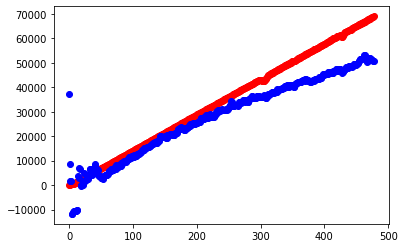

In [7]:
parameters = {'fit_intercept': [True,False],
             'copy_X': [True,False]}
linear = GridSearchCV(LinearRegression(),
                      parameters, 
                      cv=7,
                      scoring='r2',
                      n_jobs=-1)
#linear = LinearRegression(fit_intercept=False)
linear.fit(x_train, y_train)

y_tr_pred = linear.predict(x_train)
lin_reg_y_te_pred = linear.predict(x_test)

#print('linear reg score on our train data: {:.3f}'.format(sqrt(mse(y_train, y_tr_pred))))
#print('linear reg score on our test data: {:.3f}'.format(sqrt(mse(y_test, y_te_pred))))

print("Training Score ",linear.score(x_train,y_train))
linear_score = linear.score(x_test,y_test)
print("Testing Score ",linear_score)

from sklearn.metrics import r2_score
R = r2_score(y_test, lin_reg_y_te_pred)
print ('R² :',R)
#print('Best Score: ', linear.best_score_)
#print('Best Params: ', linear.best_params_)

plt.scatter(range(0,len(y_test)),y_test, color='red')
plt.scatter(range(0,len(lin_reg_y_te_pred)),lin_reg_y_te_pred, color='blue')
plt.show()
#plt.plot(y_test)
#plt.plot(lin_reg_y_te_pred)
#plt.show()

# Polynomial Regression

Training Score  0.8160865349992774
Testing Score  0.8962114524776348
R² : 0.8962114524776348
Best Params:  {'linearregression__fit_intercept': False, 'polynomialfeatures__degree': 2}


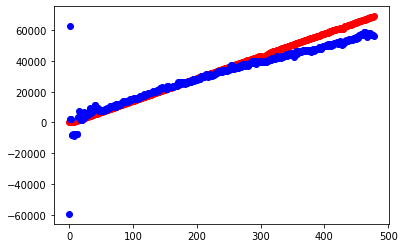

In [8]:
def PolynomialRegression(**kwargs):
    return make_pipeline(PolynomialFeatures(), LinearRegression(**kwargs))
degrees = [2,3,4,5,6 ]
param_grid = {'polynomialfeatures__degree': degrees, 'linearregression__fit_intercept': [False]}
polynomial = GridSearchCV(PolynomialRegression(),
                      param_grid, 
                      cv=5,
                      scoring='r2',
                      n_jobs=-1)
polynomial.fit(x_train, y_train)

y_tr_pred = polynomial.predict(x_train)
poly_reg_y_te_pred = polynomial.predict(x_test)

#print('linear reg score on our train data: {:.3f}'.format(sqrt(mse(y_train, y_tr_pred))))
#print('linear reg score on our test data: {:.3f}'.format(sqrt(mse(y_test, y_te_pred))))

print("Training Score ",polynomial.score(x_train,y_train))
polynomial_score = polynomial.score(x_test,y_test)
print("Testing Score ",polynomial_score)

from sklearn.metrics import r2_score
R = r2_score(y_test, poly_reg_y_te_pred)
print ('R² :',R)
#print('Best Score: ', polynomial.best_score_)
print('Best Params: ', polynomial.best_params_)

plt.scatter(range(0,len(y_test)),y_test, color='red')
plt.scatter(range(0,len(poly_reg_y_te_pred)),poly_reg_y_te_pred, color='blue')

# Ridge Regression

Training Score  0.7268414384734126
Testing Score  0.8149712168853149
Best Params:  {'alpha': 1.1288378916846883e-09, 'fit_intercept': True, 'max_iter': 10, 'solver': 'svd'}


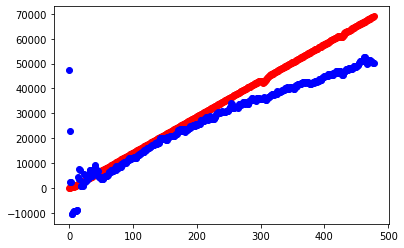

In [9]:
alphas = np.logspace(-20,10,num=20)
param_grid = {'max_iter': np.arange(10,100,10),
             'alpha': alphas,
            'solver': ['auto', 'svd'],
             'fit_intercept':[True, False]}
ridge_cv = GridSearchCV(Ridge(),
                       param_grid=param_grid,
                         cv=3, 
                         scoring='r2',
                         n_jobs=-1)

ridge_cv.fit(x_train, y_train)

y_tr_pred = ridge_cv.predict(x_train)
ridge_cv_y_te_pred = ridge_cv.predict(x_test)

print("Training Score ",ridge_cv.score(x_train,y_train))
ridge_cv_score = ridge_cv.score(x_test,y_test)
print("Testing Score ",ridge_cv_score)

#from sklearn.metrics import r2_score
#R = r2_score(y_test, y_te_pred)
#print ('R² :',R)
#print('Best Score: ', ridge_cv.best_score_)
print('Best Params: ', ridge_cv.best_params_)

plt.scatter(range(0,len(y_test)),y_test, color='red')
plt.scatter(range(0,len(ridge_cv_y_te_pred)),ridge_cv_y_te_pred, color='blue')

# Random Forrest

Training Score  0.9351024881256175
Testing Score  0.9594755155228841
Best Params:  {'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 2, 'n_estimators': 100}


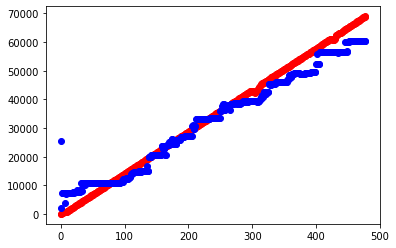

In [10]:
parameters = {  
                 'min_samples_leaf': [2, 4, 6],
                 'max_depth': np.arange(1,6,1),
                 'n_estimators': [100],
                'max_features': ['auto']
}

rf_cv = GridSearchCV( RandomForestRegressor(),
                      param_grid=parameters, 
                      cv=3, 
                      scoring='r2',
                      n_jobs=-1)

rf_cv.fit(x_train, y_train)

y_tr_pred = rf_cv.predict(x_train)
rf_cv_y_te_pred = rf_cv.predict(x_test)


print("Training Score ",rf_cv.score(x_train,y_train))
rf_cv_score = rf_cv.score(x_test,y_test)
print("Testing Score ",rf_cv_score)

#from sklearn.metrics import r2_score
#R = r2_score(y_test, y_te_pred)
#print ('R² :',R)
#print('Best Score: ', rf_cv.best_score_)
print('Best Params: ', rf_cv.best_params_)

plt.scatter(range(0,len(y_test)),y_test, color='red')
plt.scatter(range(0,len(rf_cv_y_te_pred)),rf_cv_y_te_pred, color='blue')

# Gradient Boosting Regressor

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.8s finished


Training Score  0.9533187739011401
Testing Score  0.9833082651611587
Best Params:  {'learning_rate': 0.02, 'loss': 'lad', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 20, 'n_estimators': 1500}


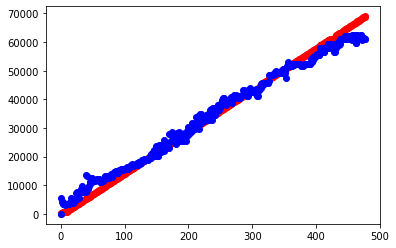

In [11]:
learning_rate = np.arange(0,0.2,0.001)
parameters = {  
                'learning_rate': [0.02], 
                'loss': ['lad'], 
                'max_depth': [5], 
                'max_features': ['sqrt'], 
                'min_samples_leaf': [10], 
                'min_samples_split': [20], 
                'n_estimators': [1500]
             }


GBoost_cv = GridSearchCV(GradientBoostingRegressor(), 
                         param_grid=parameters, 
                         n_jobs=-1, 
                         scoring='r2',
                         cv=5,
                        verbose=1)
#GBoost_cv = GradientBoostingRegressor(learning_rate=0.02)

GBoost_cv.fit(x_train, y_train)

y_tr_pred = GBoost_cv.predict(x_train)
GBoost_cv_y_te_pred = GBoost_cv.predict(x_test)

print("Training Score ",GBoost_cv.score(x_train,y_train))
GBoost_cv_score = GBoost_cv.score(x_test,y_test)
print("Testing Score ",GBoost_cv_score)

#from sklearn.metrics import r2_score
#R = r2_score(y_test, y_te_pred)
#print ('R² :',R)
#print('Best Score: ', GBoost_cv.best_score_)
print('Best Params: ', GBoost_cv.best_params_)

plt.scatter(range(0,len(y_test)),y_test, color='red')
plt.scatter(range(0,len(GBoost_cv_y_te_pred)),GBoost_cv_y_te_pred, color='blue')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 3)                 7         
_________________________________________________________________
dense_one (Dense)            (None, 64)                256       
_________________________________________________________________
dense_two (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_three (Dense)          (None, 1)                 65        
Total params: 4,488
Trainable params: 4,481
Non-trainable params: 7
_________________________________________________________________
None


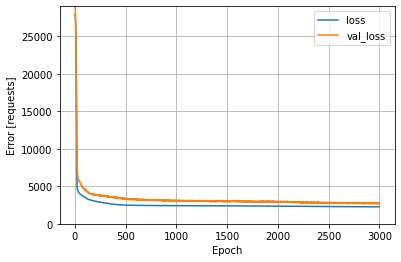

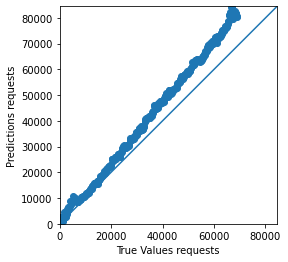

86.0248522756852
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 3)                 7         
_________________________________________________________________
dense_one (Dense)            (None, 64)                256       
_________________________________________________________________
dense_two (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_three (Dense)          (None, 1)                 65        
Total params: 4,488
Trainable params: 4,481
Non-trainable params: 7
_________________________________________________________________
None


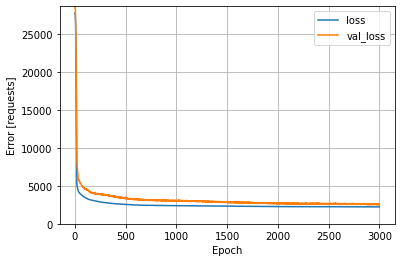

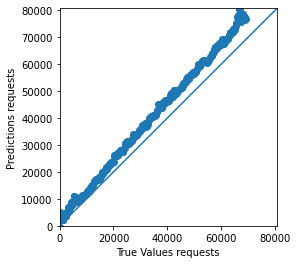

90.62650960742506
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_2 (Normalizati (None, 3)                 7         
_________________________________________________________________
dense_one (Dense)            (None, 64)                256       
_________________________________________________________________
dense_two (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_three (Dense)          (None, 1)                 65        
Total params: 4,488
Trainable params: 4,481
Non-trainable params: 7
_________________________________________________________________
None


In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, max(history.history['loss']+history.history['val_loss'])+100])
  plt.xlabel('Epoch')
  plt.ylabel('Error [requests]')
  plt.legend()
  plt.grid(True)
  return plt.show()

def plot_prediction(test_labels, test_predictions):
    a = plt.axes(aspect='equal')
    plt.scatter(test_labels, test_predictions)
    plt.xlabel('True Values requests')
    plt.ylabel('Predictions requests')
    lims = [0, max(list(test_labels)+list(test_predictions))+100]
    plt.xlim(lims)
    plt.ylim(lims)
    _ = plt.plot(lims, lims)
    return plt.show()

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
def build_and_compile_model(norm):
  model = None
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu',name="dense_one"),
      layers.Dense(64, activation='relu',name="dense_two"),
      layers.Dense(1,name="dense_three")
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

#%%time
i = 0
loss_exp = 0
nn_score = 0
test_dataset = df_ttest
test_features = test_dataset.copy()
test_labels = test_features.pop('requests')
loss, score, model = [], [], []
hist = np.empty([6,])
# k fold
X = df_t.loc[:,['total_cpu_util','total_mem_util', 'responsetime']].values
y = df_t.loc[:,['requests']].values
kf = KFold(n_splits=6, random_state=42, shuffle=True)
for train_index, test_index in kf.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    train_features, val_features = X[train_index], X[test_index]
    train_labels, val_labels = y[train_index], y[test_index]

# Divide dataset
#train_dataset = df_t.sample(frac=0.8, random_state=0)
#val_dataset = df_t.drop(train_dataset.index)
#test_dataset = df_ttest

#train_features = train_dataset.copy()
#val_features = val_dataset.copy()
#test_features = test_dataset.copy()

# Create labels
#train_labels = train_features.pop('requests')
#val_labels = val_features.pop('requests')
#test_labels = test_features.pop('requests')

# Normalization
    input = np.array(train_features)
    input_normalizer = preprocessing.Normalization(input_shape=[3,])
    input_normalizer.adapt(input)

# Create Model
    
    dnn_model = build_and_compile_model(input_normalizer)

    print(dnn_model.summary())

    history = dnn_model.fit(
        train_features, train_labels,
        validation_split=0.2,
        verbose=0, epochs=3000)
    #print(history)
    plot_loss(history)
    loss_cal=dnn_model.evaluate(val_features, val_labels,verbose=0)
    loss.append(loss_cal)
    ## Make Predictions
    test_predictions = dnn_model.predict(test_features).flatten()

    plot_prediction(test_labels, test_predictions)
    R = r2_score(test_labels, test_predictions)*100
    print(R)
    if(loss_cal<loss_exp) or (i==0):
        nn_score = R
        loss_exp = loss_cal
        nn_prediction = test_predictions
    model.append('dnn_model_'+str(i))
    score.append(R)
    i = i+1
    #test_results['dnn_model_'+str(i)] = [dnn_model.evaluate(
    #    val_features, val_labels,
    #    verbose=0), R]
model = np.array(model)
score = np.array(score)
loss = np.array(loss)

data = np.array([model, loss, score]).T
pd.DataFrame(data,columns=["model", "loss", "score"])

In [ ]:
rcParams['figure.figsize'] = 5, 5
rcParams["legend.loc"] = 'upper left'
rcParams['axes.labelsize'] = 5
rcParams['axes.titlesize'] = 5
rcParams["font.size"] = 10
plt.plot(test_labels, color='green',label='True Value')
plt.plot(lin_reg_y_te_pred, color='red', label='Linear Regression')
plt.plot(poly_reg_y_te_pred, color='blue', label='Polynomial Linear Reg')
plt.plot(ridge_cv_y_te_pred, color='brown', label='Ridge Reg')
plt.plot(rf_cv_y_te_pred, color='grey', label='Random Forrest')
plt.plot(nn_prediction, color='violet', label='Deep Neural Network')
plt.legend(loc="lower right")
plt.show()

In [ ]:
models = np.array(['Linear Regression', 'Polynomial Linear Reg', 'Ridge Reg', 'Random Forrest', 'Deep Neural Network'])
model_score = np.array([linear_score*100, polynomial_score*100, ridge_cv_score*100, rf_cv_score*100, nn_score])
data = np.array([models, model_score]).T
pd.DataFrame(data,columns=["models", "model_score"])